# Surface observation postprocessing 


In these note books we try some machine learning techniques on a real world but simple problem.

We are trying to improve the ECMWF IFS forecast of temperature using postprocessing. 

Specifically we are trying to predict the different between station observations 2m-temperature and the IFS forecast prediction at the nearest gridpoint to the observation location.

We will explore several physically motivated predictors.

# Using fully connected neural networks

In [ ]:
#Install the package for our dataset
!pip install climetlab-mltc-surface-observation-postprocessing --quiet

In [1]:
# An example of using machine learning to model weather forecast error 
# based on work of Matthew Chantry and Fenwick Cooper as part of work 
# funded by IFAB (https://www.ifabfoundation.org/)

# A few imports of tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sop_utils import imgBufferFromVectors

#pip install climetlab-mltc-sop

import climetlab as cml

In [2]:
# Load a list of 36 hour forecast errors in 2m temperature.
# The forecasts come from ECMWF's high resolution forecast system.
# The measurements come from around 8000 weather stations around the world.
forecast_error = cml.load_dataset('mltc-surface-observation-postprocessing',field='forecast_error').to_numpy()

# We suspect that the errors in the forecast can be explained simply by the time of day.

# Load the local time of day corresponding to when the measurements were made.
time_of_day = cml.load_dataset('mltc-surface-observation-postprocessing',field='time_of_day').to_numpy()

# Later we will add in the soil temperature
soil_temperature = cml.load_dataset('mltc-surface-observation-postprocessing',field='soil_temperature').to_numpy()

# Note that an important step of data preprocessing has already been carried out in the curation of the dataset.
# Spurious data has already been removed from the dataset based upon a range of categories,
# e.g. stations with inconsistent measurement locations, repeated values, or even physically 
# invalid numbers (>100C).
# If you are starting on a new project this is a key step to clean the data.

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


In [3]:
#Split each of the predictands and predictors in a random train/test split
# we use 80% of the data for training & 20% for testing

# Here the data has already been anonymised, so we cannot use information about
# stations or time to ensure independence of our dataset.
# With more meta-data we could follow the lessons learnt earlier today
# and ensure the data subsets are independent
(forecast_error_train, forecast_error_test, 
    time_of_day_train, time_of_day_test, 
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error,
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2,
                                                                       random_state = 42,
                                                                      )

In [4]:
#Next we want to standardise the data.
# This will help train the neural network, particularly in larger problems.
# Here we will use the StandardScalar, which divides by the mean and std of the *training* dataset.
# Sometimes another approach will be more appropriate, e.g. a log transform for precipitation data.

scaler = StandardScaler()
scaler.fit(time_of_day_train)
print("Mean:",scaler.mean_,", Variance:",scaler.var_)

time_of_day_train_norm = scaler.transform(time_of_day_train)
time_of_day_test_norm = scaler.transform(time_of_day_test)


Mean: [13.66310873] , Variance: [25.66713122]


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

#There are several ways to build a Neural network in Keras/Tensorflow

#The simplest is the sequential approach
#here we write a function which outputs a model, ready to be trained

def fullyconnected_sequential(input_shape: int, #How many predictors?
                              width: int, #How wide should the layers be?
                              depth: int, #How many layers?
                              activation: str, #What nonlinearity to use?
                              learning_rate = 10**(-3), #What learning rate?
                              final_activation: str = 'linear' #Final activation
                             ): 
    #Create a model object
    model = Sequential()
    #Then just stack layers on top of one another
    #the first specifies the shape of the inputs expected input 
    model.add(Input(input_shape,name="Inputs"))
    
    #Then we stack on depth number of consectutive dense layers
    #To write more compact code we can include the activation
    #function we want to apply after each Dense block in the 
    #call itself.
    for i in range(depth):
        model.add(Dense(width,activation=activation))
        
    #Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1,activation=final_activation))
    
    #Next we need to specify the optimiser we want to use
    # and what learning rate to use
    opt = Adam(learning_rate)
    
    #Finally we compile the model, specifying the loss we 
    # want to minimise
    model.compile(loss='mse', optimizer=opt)
    
    #Afterwards we can summarise the model to see the shapes
    model.summary()
    return model
    
#For more advanced architectures, it's good to use the 
# functional approach to writing networks. This is very similar
# to the syntax of Pytorch.
#Here we stitch together a model, by passing one layer into the next
def fullyconnected_functional(input_shape: int, 
                              width: int, 
                              depth: int, 
                              activation: str,
                              learning_rate = 10**(-3),
                              final_activation: str = 'linear'
):
    #First we create an input layer
    inputs = Input(input_shape,name="Inputs")
    #Pass it to a name we will reuse
    hidden = inputs
    for i in range(depth):
        #Now we repeatedly apply a Dense layer to the object
        #each time this adds another layer onto the stack
        hidden = Dense(width,activation=activation)(hidden)
    #Finally stitch on the output layer
    output = Dense(1,activation='linear')(hidden)
    #And the model itself is created by specifying the input
    # layers and output layers.
    # With this approach we can create a model with multiple
    # inputs and outputs, if appropriate for the problem.
    mod= Model(inputs=inputs,outputs=output)
    opt = Adam(learning_rate)
    mod.compile(loss='mse', optimizer=opt)
    mod.summary()
    return mod


In [6]:
# Create neural network object
# you can use either of the functions we defined above

#Try changing the depth and see what the summary says
model = fullyconnected_functional(
        time_of_day_train_norm.shape[1],
        depth=3,width=32,
             activation='tanh',learning_rate=10**(-3))

#Note, we have 2000 parameters to learn. This is many fewer than the 
# number of examples, so we should not be too worried about overfitting.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________


2022-04-13 10:06:56.629812: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-13 10:06:56.630476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 10:06:56.633092: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# Train the model using the data
model.fit(time_of_day_train_norm, 
          forecast_error_train,
          validation_data=(time_of_day_test_norm, forecast_error_test),
          batch_size = 128,
          epochs = 3
         )

2022-04-13 10:06:56.933642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-13 10:06:56.934511: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2992965000 Hz


Epoch 1/3
32910/32910 [==============================] - 45s 1ms/step - loss: 4.9014 - val_loss: 4.8837
Epoch 2/3
32910/32910 [==============================] - 46s 1ms/step - loss: 4.8733 - val_loss: 4.8751
Epoch 3/3
32910/32910 [==============================] - 44s 1ms/step - loss: 4.8703 - val_loss: 4.8788


In this problem we have a large amount of data and a relatively smal number of parameters to train, we therefore see that the model converges very quickly, with the loss decreasing little after the first epoch.

In other problems it may take far longer training to reach this point.

In [8]:
#Let's see how our model works across all the hours of the day
x_rep = np.arange(0,24,0.001)[...,np.newaxis]
x_rep_norm = scaler.transform(x_rep)
y = model.predict(x_rep_norm)

In [9]:
# Make an image of the time of day against the forecast error
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)

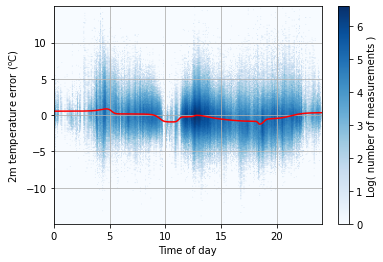

In [10]:
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel('2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x_rep,y,'red')

plt.show()

# Note: The model (red line) is better than nothing, but does not account for the variation
#       in 2m temperature error at single time of day (eg. at 14:00).
#
#       Another predictor is required. We try using the soil temperature.
#
#       In comparison to the regression model, the result of the neural network is
#       less smooth which can be a good OR a bad thing

## Adding more predictors

Next we will add a second predictor, the model soil temperature.

As we will see below, there is a complex structure in the pattern of forecast error in the 2D space of time of day & soil temperature. How well can the model learn this?


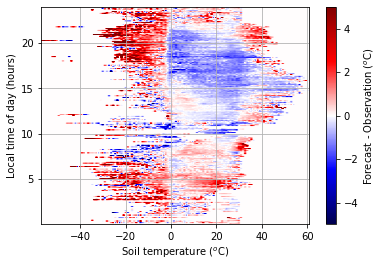

In [11]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                128, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

In the above we see clear structure, where the in evening the forecast is too warm if the soil is frozen and too cold if the soil is not.

Can we learn a good representation of this error pattern?

In [12]:
# Fit a NN using Keras/Tensorflow -- again, this may take a couple of minutes

#Create the input features
X_train = np.concatenate([time_of_day_train, soil_temperature_train],axis=-1)
X_test = np.concatenate([time_of_day_test, soil_temperature_test],axis=-1)

#Standardise the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#Construct a model, this time with 2 predictors
model_with_soil = fullyconnected_functional(X_train.shape[-1],
                   depth=3,
                   width=32,
                   activation='tanh',
                   learning_rate=10**(-3))

# Alternative activation functions are tanh, sigmoid, softmax, relu, softplus...

# Train the model using the data
model_with_soil.fit(X_train, forecast_error_train,
                    validation_data=(X_test, forecast_error_test),
                    batch_size = 128,
                    epochs = 3)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
32910/32910 [==============================] - 50s 1ms/step - loss: 4.7637 - val_loss: 4.6745
Epoch 2/3
32910/329

In [13]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test - model_with_soil.predict(X_test)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))


Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.553522923168081
Root Mean Squared Error Corrected: 2.157600569846628


### By using two predictors we can impove the forecast of 2m-temperature by ~0.1C.

### Let's see how the model corrects the forecast across the full 2D space.

In [14]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image, this covers
# the range of data observed in the data
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# Create the input data
input_buffer = np.stack(np.meshgrid(y_tod,x_st),axis=-1)
X_plot = scaler.transform(input_buffer.reshape(-1,X_train.shape[-1]))

#Predict and reshape prediction back to 2D plot
raw_pred = model_with_soil.predict(X_plot)
model_buffer = raw_pred.reshape(input_buffer.shape[:-1])

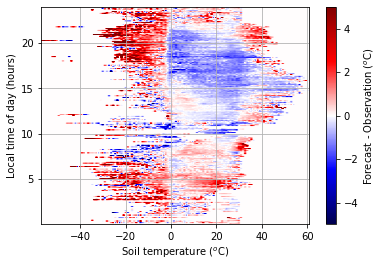

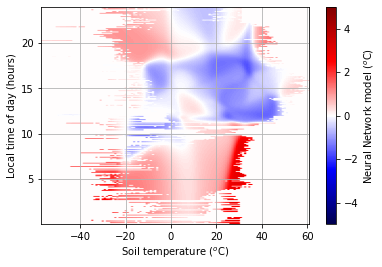

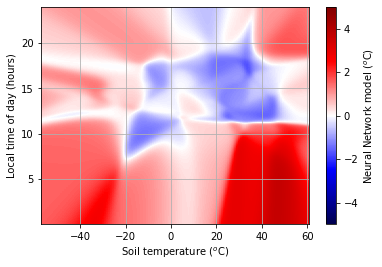

In [15]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Neural Network model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Neural Network model ($^o$C)')

plt.show()

As we add more predictors and complexity to our model, it becomes better and better. But, our measurements of the forecast error are not perfect. There is some noise. We don't want our model to capture this. But a complex model will. We need a simpler model, or more data. Fitting a model that is too complex for the data is called "overfitting". Here we have a large number of observations and still relatively small number of free parameters, so overfitting is unlikely. We see that during training our errors on the training & testing dataset are comparable.

Away from where data has been provided the model does not have constraints. We should not trust this part of the space.

We also see different model corrections for hour 23 and hour 0, when these should be closely correlated.


### Can you beat my predictions by changing the activation, depth, width, learning rate?

### Is there a way of building in any prior knowledge to even this simple setup?

### Perhaps you can encode the fact that 0 hour follows 24?

### Does this help the prediction?